### Imports

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from math import pi, ceil
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from diversify.session import SpotifySession

In [2]:
%matplotlib inline

sns.set(rc={'figure.figsize': (12,8)})

warnings.filterwarnings('ignore')

### About Audio Features

| Column   |      Value Type      |  Value Description |
|:----------|:--------------------|:-------------------|
| id | - | The Spotify ID for the track. |
| name | string | Name of the track. |
| artist | string | Artist who plays the track. |
| artist_id | - | The Spotify ID for the artist. |
| album | string | The album where the track is on. |
| album_id | - | The Spotify ID for the album. | 
| popularity | int | The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.|
| duration_ms | int | The duration of the track in milliseconds. |
| key | int | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
| mode | int | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
| acousticness | float | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
| danceability | float | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| energy | float | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
| instrumentalness | float | Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
| liveness | float | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
| loudness | float | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. |
| speechiness | float | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| valence | float | 	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
| tempo | float | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |


### Importing data

- Songs to cluster

In [268]:
df_songs = pd.read_csv('datasets/songs_to_cluster.csv')
df_songs.head(3)

,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,137826,3mf4l3O9xn8JukaUETnZFt,Chá De Sofrimento,37,0.411,0.666,0.859,0.000000,8,0.3140,-3.836,1,0.0304,156.990,0.933
1,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,145883,48cryfhSXQGrWyhnmXEOEg,Nota 1.000,38,0.564,0.707,0.851,0.000094,7,0.3300,-5.008,0,0.0322,153.929,0.871
2,Deixa,7wj45LWz6uIcyBd8iqdlZ5,Bruna Magalhães,108y6vREhgAIvgvm1Cq54p,207209,0m52ru9yO561lgoMHyclcC,Deixa,0,0.801,0.299,0.159,0.000000,11,0.0611,-16.540,0,0.0357,183.227,0.180


In [269]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 19 columns):
album               6500 non-null object
album_id            6500 non-null object
artist              6500 non-null object
artist_id           6500 non-null object
duration_ms         6500 non-null int64
id                  6500 non-null object
name                6500 non-null object
popularity          6500 non-null int64
acousticness        6500 non-null float64
danceability        6500 non-null float64
energy              6500 non-null float64
instrumentalness    6500 non-null float64
key                 6500 non-null int64
liveness            6500 non-null float64
loudness            6500 non-null float64
mode                6500 non-null int64
speechiness         6500 non-null float64
tempo               6500 non-null float64
valence             6500 non-null float64
dtypes: float64(9), int64(4), object(6)
memory usage: 964.9+ KB


In [270]:
df_songs.describe()

,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,6.500000e+03,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
mean,2.208090e+05,48.984308,0.293562,0.605050,0.661835,0.101119,5.283692,0.223859,-7.621361,0.641692,0.089147,123.111848,0.540776
std,8.607416e+04,20.803480,0.298453,0.166257,0.232170,0.251975,3.572666,0.209840,4.429930,0.479540,0.089175,28.578793,0.253939
min,4.544000e+04,0.000000,0.000002,0.000000,0.000255,0.000000,0.000000,0.020900,-42.238000,0.000000,0.000000,0.000000,0.000000
25%,1.760972e+05,37.000000,0.022700,0.495000,0.506000,0.000000,2.000000,0.094800,-9.358000,0.000000,0.037800,99.988750,0.340000
50%,2.071930e+05,52.000000,0.193000,0.619000,0.702000,0.000008,5.000000,0.132000,-6.577500,1.000000,0.054200,124.675500,0.548000
75%,2.461378e+05,63.000000,0.513000,0.727000,0.855000,0.005110,8.000000,0.284000,-4.699000,1.000000,0.099325,140.068000,0.750000
max,3.128960e+06,100.000000,0.996000,0.981000,0.999000,0.982000,11.000000,0.989000,0.858000,1.000000,0.904000,210.466000,0.984000


- Users songs

In [401]:
df_user = pd.read_csv('datasets/user_songs/my_songs.csv')
df_user.head(3)

,name,id,popularity,duration_ms,album,album_id,artist,artist_id,speechiness,valence,mode,liveness,key,danceability,loudness,acousticness,instrumentalness,energy,tempo
0,Motions,5p1PQOz5uCa2oMRKkX0oKI,36,180000,Skeletons,6uc6QxoKV2rtCssHIH4BQe,Driveways,4OuSiJSnuRsK0dTM0dtm1R,0.1090,0.534,0,0.137,3,0.485,-6.169,0.001530,0.000000,0.977,138.967
1,South of the Border (feat. Camila Cabello & Ca...,3vQhEd4lOg4mAV6CHCgoHW,72,173454,South of the Border (feat. Camila Cabello & Ca...,05Bru0ZVTxp4orAyrZIA77,Ed Sheeran,6eUKZXaKkcviH0Ku9w2n3V,0.0404,0.491,1,0.335,5,0.789,-4.388,0.220000,0.000046,0.858,110.012
2,Nostalgia,2VEwYtDHSemqPhMOGixhPg,31,242800,Mr. Pain,3Q89u9avFB7FjtWej4OV30,Dayshell,4yextvMjXxQXzyQkyS1jYX,0.0300,0.597,1,0.291,1,0.502,-3.299,0.000312,0.000000,0.891,98.998


In [402]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7131 entries, 0 to 7130
Data columns (total 19 columns):
name                7130 non-null object
id                  7131 non-null object
popularity          7131 non-null int64
duration_ms         7131 non-null int64
album               7130 non-null object
album_id            7131 non-null object
artist              7130 non-null object
artist_id           7131 non-null object
speechiness         7131 non-null float64
valence             7131 non-null float64
mode                7131 non-null int64
liveness            7131 non-null float64
key                 7131 non-null int64
danceability        7131 non-null float64
loudness            7131 non-null float64
acousticness        7131 non-null float64
instrumentalness    7131 non-null float64
energy              7131 non-null float64
tempo               7131 non-null float64
dtypes: float64(9), int64(4), object(6)
memory usage: 1.0+ MB


In [403]:
df_user.describe()

,popularity,duration_ms,speechiness,valence,mode,liveness,key,danceability,loudness,acousticness,instrumentalness,energy,tempo
count,7131.000000,7131.000000,7131.000000,7131.000000,7131.000000,7131.000000,7131.000000,7131.000000,7131.000000,7131.000000,7131.000000,7131.000000,7131.000000
mean,35.670313,224158.802132,0.080113,0.440212,0.588277,0.214645,5.357734,0.485156,-5.168289,0.069796,0.036072,0.833631,130.463318
std,20.982574,49099.726354,0.060719,0.207176,0.492180,0.161513,3.495467,0.130484,2.204939,0.171690,0.135068,0.167277,30.877176
min,0.000000,49146.000000,0.022500,0.030300,0.000000,0.016400,0.000000,0.099300,-26.401000,0.000001,0.000000,0.036500,49.452000
25%,22.000000,194513.000000,0.040400,0.282000,0.000000,0.100000,2.000000,0.404000,-6.103000,0.000276,0.000000,0.773000,104.995500
50%,37.000000,218453.000000,0.059900,0.423000,1.000000,0.152000,5.000000,0.485000,-4.741000,0.002640,0.000015,0.894000,129.084000
75%,51.000000,246127.000000,0.096700,0.587500,1.000000,0.306000,8.000000,0.565000,-3.717000,0.032400,0.001200,0.952000,155.032000
max,98.000000,557700.000000,0.589000,0.977000,1.000000,0.993000,11.000000,0.964000,0.184000,0.987000,0.987000,0.998000,215.917000


### Train dataset analysis

- Verifying columns

In [275]:
df_songs.columns

Index(['album', 'album_id', 'artist', 'artist_id', 'duration_ms', 'id', 'name',
       'popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence'],
      dtype='object')

- Verifying correlations between features

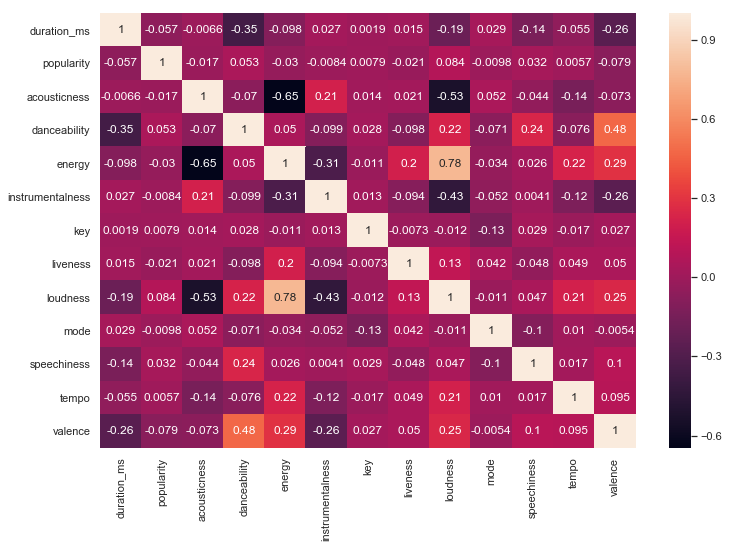

In [276]:
ax = sns.heatmap(df_songs.corr(), annot=True)
plt.show()

- Analyzing the distributions of the continuous features

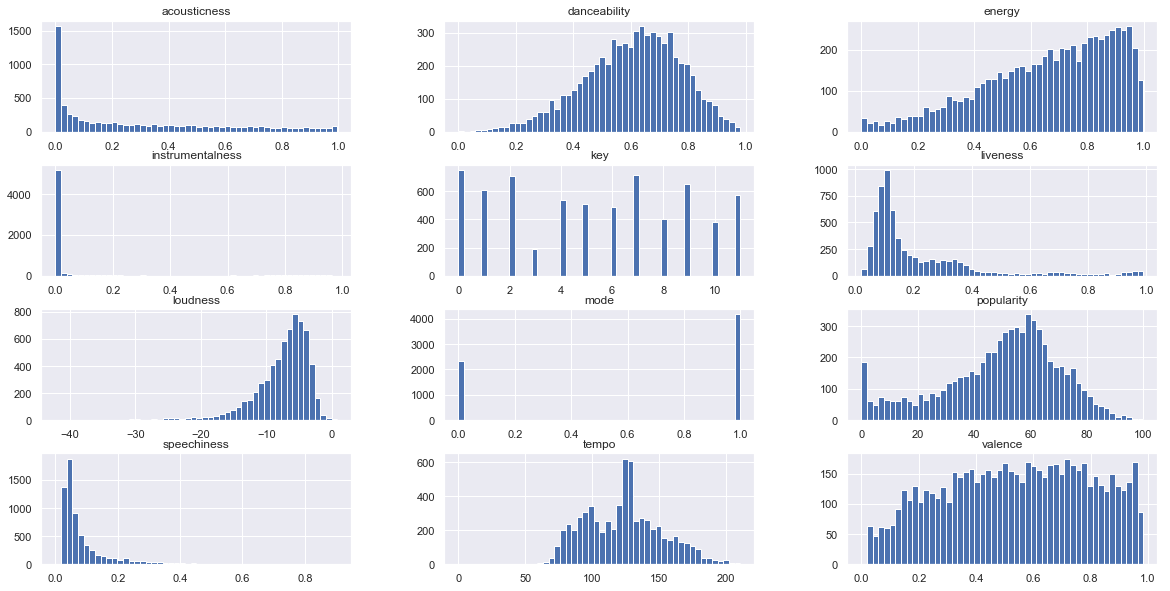

In [277]:
df_songs[['popularity', 'acousticness', 'danceability', 'energy', 
           'instrumentalness', 'key','liveness','loudness', 'mode', 'speechiness',
           'tempo', 'valence']].hist(bins=50, figsize=(20,10))
plt.show()

In [278]:
columns_to_cluster = ['popularity', 'acousticness', 'danceability', 
                      'energy', 'instrumentalness', 'liveness',
                      'loudness', 'speechiness', 'valence']

### Preprocessing data

- Changing the data scale

Using StandardScaler

In [60]:
# Currently using MinMaxScaler, due to minor inertia values in KMeans
ss = StandardScaler()

songs_scaled = ss.fit_transform(df_songs[columns_to_cluster])
print("Base de músicas: ", songs_scaled[0,:])

user_scaled = ss.fit_transform(df_user[columns_to_cluster])
print("Dados de usuários: ", user_scaled[0,:])

Base de músicas:  [-0.57611656  0.39351789  0.36662849  0.84929458 -0.40133461  0.42960597
  0.85456257 -0.65883238  1.54467758]
Dados de usuários:  [ 0.18737283  2.32094603 -2.65769796 -1.76058298 -0.14301338  0.46196365
 -0.60980366 -0.89574973 -0.57555324]


Using MinMaxScaler

In [404]:
mms = MinMaxScaler()

songs_scaled = mms.fit_transform(df_songs[columns_to_cluster])
print("Base de músicas: ", songs_scaled[0,:])

user_scaled = mms.fit_transform(df_user[columns_to_cluster])
print("Dados de usuários: ", user_scaled[0,:])

Base de músicas:  [0.37       0.41264952 0.67889908 0.85982408 0.         0.30275798
 0.89108038 0.03362832 0.94817073]
Dados de usuários:  [0.36734694 0.00154914 0.44605065 0.97815913 0.         0.12348966
 0.76103066 0.15269197 0.53205873]


In [405]:
columns_to_cluster_scaled = ['popularity_scaled', 'acousticness_scaled', 'danceability_scaled', 
                             'energy_scaled', 'instrumentalness_scaled', 'liveness_scaled',
                             'loudness_scaled', 'speechiness_scaled', 'valence_scaled']

df_songs_scaled = pd.DataFrame(songs_scaled, columns=columns_to_cluster_scaled)

- Scaled Heatmap

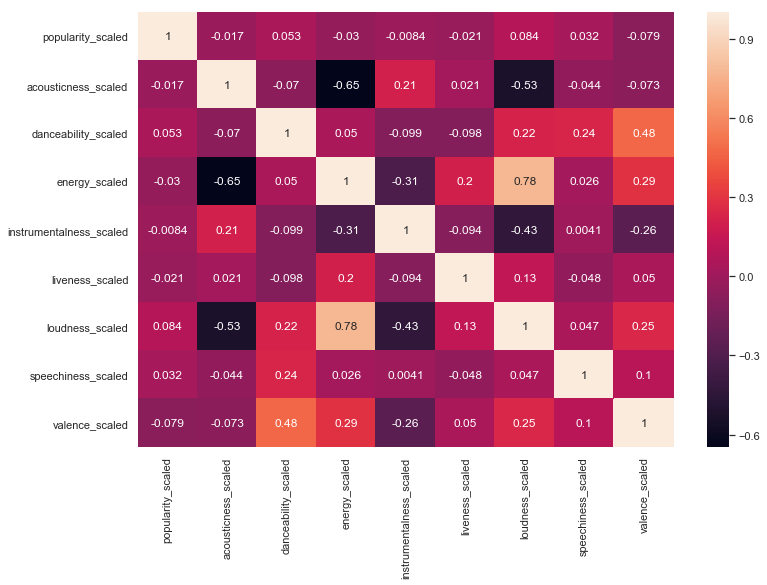

In [281]:
ax = sns.heatmap(df_songs_scaled.corr(), annot=True)
plt.show()

### Training the model

In [282]:
n_clusters = range(2,21)
ssd = []
sc = []

for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(songs_scaled)
    preds = km.predict(songs_scaled) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(songs_scaled, preds, metric='euclidean')
    sc.append(score)
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.3012305504924181
Number of Clusters = 3, Silhouette Score = 0.1908176898953157
Number of Clusters = 4, Silhouette Score = 0.19726218949463145
Number of Clusters = 5, Silhouette Score = 0.21503754737025266
Number of Clusters = 6, Silhouette Score = 0.2243945887385722
Number of Clusters = 7, Silhouette Score = 0.19789786262285794
Number of Clusters = 8, Silhouette Score = 0.1994331570974855
Number of Clusters = 9, Silhouette Score = 0.19311115329932965
Number of Clusters = 10, Silhouette Score = 0.19205432814298462
Number of Clusters = 11, Silhouette Score = 0.18377165294535258
Number of Clusters = 12, Silhouette Score = 0.18209997187329122
Number of Clusters = 13, Silhouette Score = 0.16974953656314448
Number of Clusters = 14, Silhouette Score = 0.17616334711793058
Number of Clusters = 15, Silhouette Score = 0.15953366253903123
Number of Clusters = 16, Silhouette Score = 0.16498047377381875
Number of Clusters = 17, Silhouette Score = 0.161322

- Silhouette score plot

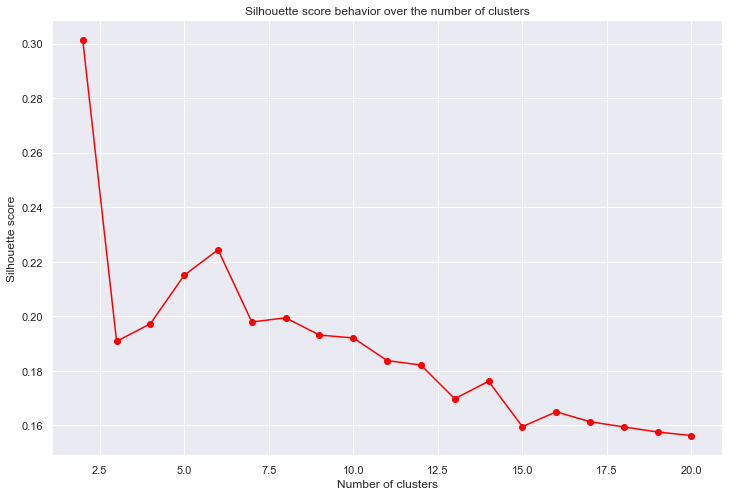

In [283]:
plt.plot(n_clusters, sc, marker='.', markersize=12, color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score behavior over the number of clusters')
plt.show()

- Elbow method plot

In [284]:
for n, s in zip(n_clusters, ssd):
    print('Number of Clusters = {}, Sum of Squared Distances = {}'.format(n, s))

Number of Clusters = 2, Sum of Squared Distances = 2054.478184043158
Number of Clusters = 3, Sum of Squared Distances = 1747.7117505662782
Number of Clusters = 4, Sum of Squared Distances = 1534.4945860038183
Number of Clusters = 5, Sum of Squared Distances = 1356.3322912391086
Number of Clusters = 6, Sum of Squared Distances = 1231.8743583363039
Number of Clusters = 7, Sum of Squared Distances = 1141.6010781122363
Number of Clusters = 8, Sum of Squared Distances = 1062.5578242896665
Number of Clusters = 9, Sum of Squared Distances = 1003.990169018867
Number of Clusters = 10, Sum of Squared Distances = 964.6402943933394
Number of Clusters = 11, Sum of Squared Distances = 925.5270046330388
Number of Clusters = 12, Sum of Squared Distances = 893.26074562849
Number of Clusters = 13, Sum of Squared Distances = 872.3399380237605
Number of Clusters = 14, Sum of Squared Distances = 849.4144367732132
Number of Clusters = 15, Sum of Squared Distances = 823.1591029292358
Number of Clusters = 16,

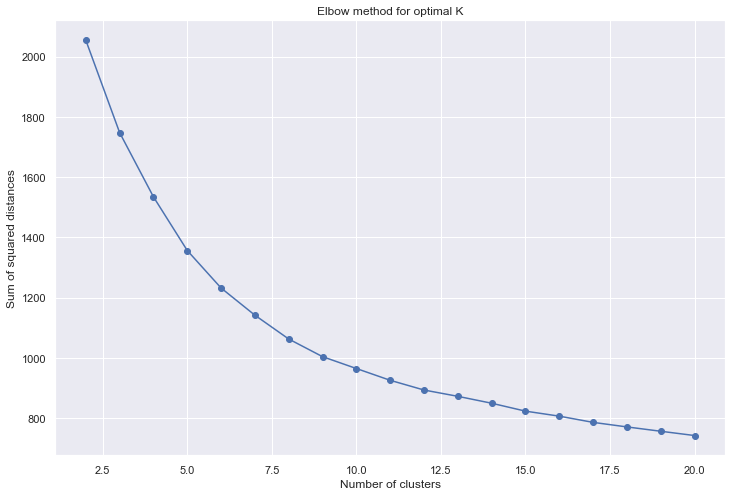

In [285]:
plt.plot(n_clusters, ssd, marker='.', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal K')
plt.show()

- Fixing the number of clusters

In [286]:
k=10

model = KMeans(n_clusters=k, random_state=42).fit(songs_scaled)
pred = model.predict(songs_scaled)
print('10 first clusters: ', model.labels_[:10])

10 first clusters:  [1 1 5 3 1 5 5 5 3 3]


### Visualizing the clusters

- Amount of songs per cluster

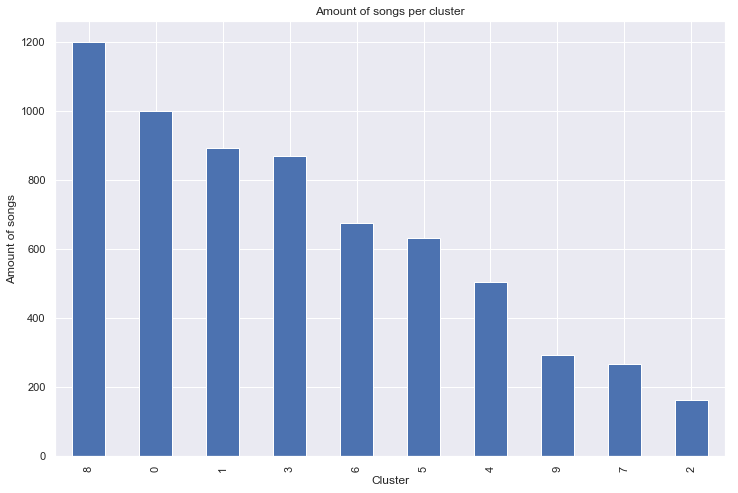

In [406]:
df_songs_scaled['cluster'] = model.labels_

df_songs_scaled['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Amount of songs')
plt.title('Amount of songs per cluster')
plt.show()

In [407]:
display(df_songs_scaled['cluster'].value_counts())
minor_cluster = df_songs_scaled['cluster'].value_counts().tail(1)
print("Amount of songs in the smallest cluster: ", int(minor_cluster.values))

8    1201
0    1002
1     893
3     869
6     676
5     633
4     505
9     292
7     267
2     162
Name: cluster, dtype: int64

Amount of songs in the smallest cluster:  162


- Sampling songs from each cluster

In [408]:
df_songs_joined = pd.concat([df_songs,df_songs_scaled], axis=1).set_index('cluster')

for cluster in range(k):
    display(df_songs_joined.loc[cluster, ['artist','name','album']].sample(frac=1).head(10))

,artist,name,album
cluster,,,
0,Dropgun,Together As One - Radio Edit,Together As One
0,Eluveitie,Ambiramus,Ategnatos
0,Motörhead,Overkill,Overkill (Deluxe Edition)
0,Avicii,Without You (feat. Sandro Cavazza),AVĪCI (01)
0,Ivan Gough,In My Mind (feat. Georgi Kay) - Axwell Radio Edit,In My Mind (feat. Georgi Kay)
0,Two Door Cinema Club,Once,Once
0,Válvera,Demons of War,Demons of War
0,The Knocks,No Requests,New York Luau / No Requests
0,Torture Squad,Blood Sacrifice,Far Beyond Existence


,artist,name,album
cluster,,,
1,Ananda,Quero Que Tu Vá,Quero Que Tu Vá
1,Gian & Giovani,Eu Busco uma Estrela,Top Sertanejo
1,Saia Rodada,Já Que Me Ensinou a Beber,Saia na Serra
1,Dani Russo,Brincar de Vida,Brincar de Vida
1,Thaíde,Caboclinho Comum,Caboclinho Comum
1,Péricles,Linguagem dos Olhos - Ao Vivo,Acústico (Ao Vivo)
1,Ceceu Valença,Doce Menina,Doce Menina
1,Lucy Alves,Amor À Perder De Vista,Lucy Alves
1,Mallu Magalhães,Love You,Vem


,artist,name,album
cluster,,,
2,Alison Balsom,Piazzolla: Libertango,The Sound of Piazzolla
2,Johann Sebastian Bach,"The Well-Tempered Clavier: Book 1, BWV 846-869...",Piano Book (Deluxe Edition)
2,Meriheini Luoto,Metsänpeitto: VIII,Metsänpeitto 2
2,François Couperin,Les Baricades Mistérieuses (6e ordre),Couperin: Tic Toc Choc
2,Hector Berlioz,"Le carnaval romain, Op. 9, H 95","Berlioz: Le carnaval romain, Op. 9, H 95"
2,Ralph Vaughan Williams,The Lark Ascending,The Lark Ascending
2,John Tavener,The Lamb,Tavener: The Lamb
2,Astor Piazzolla,Las Estaciones Porteñas (Arr. S. Assad for Sol...,Amor Fati
2,RIOPY,Ukiyo,Tree of Light


,artist,name,album
cluster,,,
3,girl in red,we fell in love in october,we fell in love in october / forget her
3,Paulinho Da Viola,No Pagode Do Vavá,Argumento
3,Priscilla Alcantara,Sem Querer,Gente
3,GoldLink,Days Like This (feat. Khalid),Diaspora
3,ODESZA,Late Night,A Moment Apart
3,Gabriela Rocha,Estou Seguro - Ao Vivo,Estou Seguro (Ao Vivo)
3,Lonestar,Amazed,Playlist: The Very Best Of Lonestar
3,Radiohead,Creep,Pablo Honey
3,MC Rodolfinho,Partidas Recentes,Partidas Recentes


,artist,name,album
cluster,,,
4,Lucas Plant,Barulho do Mar,Barulho do Mar
4,Jeito Moleque,Só pro Meu Prazer - Ao Vivo,Só pro Meu Prazer (Ao Vivo)
4,Chico César,Palavra Mágica - Ao Vivo,Estado de Poesia (Ao Vivo)
4,Antony & Gabriel,Bruninha,Bruninha
4,Naiara Azevedo,Avisa Que Eu Cheguei,Avisa Que Eu Cheguei
4,Yasmin Santos,Saudade em Gotas (feat. Wesley Safadão) - Ao Vivo,Yasmin Santos Ao Vivo em São Paulo - EP 3
4,Marcelo Markes,Sinto Fluir - Ao Vivo,Sinto Fluir (Ao Vivo)
4,Daniela Araújo,Janeiro - Ao Vivo,Verão (Ao Vivo)
4,É O Tchan,Dança Da Cordinha,Na Cabeça E Na Cintura


,artist,name,album
cluster,,,
5,Birdy,Skinny Love,Fire Within
5,The xx,Angels,Coexist
5,Samico,Além-Mar,Além-Mar
5,Jason Isbell and the 400 Unit,If We Were Vampires,The Nashville Sound
5,Os Morenos,Teu Charme,Teu Charme
5,Zé Ramalho,Chão de Giz - Ao Vivo,O Grande Encontro
5,Dan Hill,Sometimes When We Touch,Longer Fuse
5,autumn keys,Impermanence,Impermanence
5,invention_,Dxy_Drmng,Chillhop Daydreams


,artist,name,album
cluster,,,
6,Grand Magus,Brother of the Storm,Brother of the Storm
6,Metallica,Seek & Destroy,Kill 'Em All
6,Cartola,O Sol Nascerá (A Sorrir),Cartola (1974)
6,Bob Seger,Ramblin' Gamblin' Man,Ramblin' Gamblin' Man
6,Wonder Girls,Nobody (Eng Ver.),Nobody (Eng Ver.)
6,4 Non Blondes,What's Up?,"Bigger, Better, Faster, More !"
6,DJ Andrade,Eu Tenho um Lembrete,Eu Tenho um Lembrete
6,Stephen Marley,Break Us Apart,Revelation Part 1: The Root Of Life
6,Mc Romântico,Sequência de Toma! Toma!,Sequência de Toma! Toma!


,artist,name,album
cluster,,,
7,Garot Michael Conklin,Tarumi,Tarumi
7,Milkz,midnight,Digital Nomad
7,santpoort,lost ones,lost ones
7,Smeyeul.,relax,always temporary
7,Andrew Norman,For Ashley,Ash
7,Idealism,illusions,Chillhop Essentials Fall 2018
7,L'Indécis,Soulful,Playtime
7,Styn,Flor Passionis,Flor Passionis
7,n o r m a l,al pasito/timeless,al pasito timeless


,artist,name,album
cluster,,,
8,Vinny,Heloisa mexe a cadeira,Todomundo
8,Orange Juice,Rip It Up,Rip It Up
8,Janaynna,"Cê Tá Bem, Eu Tô Incrível","Cê Tá Bem, Eu Tô Incrível"
8,Blossoms,Honey Sweet,Blossoms
8,Minutemen,Corona,Double Nickels on the Dime
8,Yellow Claw,Baila Conmigo,Baila Conmigo
8,Ed Sheeran,BLOW (with Chris Stapleton & Bruno Mars),No.6 Collaborations Project
8,Tiny Moving Parts,Medicine,breathe
8,UCLÃ,Nas Alturas,Nas Alturas


,artist,name,album
cluster,,,
9,deadmau5,Faxing Berlin,Random Album Title
9,Elza Soares,Libertação,Libertação
9,LOthief,Dirty Talk,Dirty Talk
9,Jorge Milliano,Mental Fallout,Dosages
9,Thomas Newson,Goes Like This,Goes Like This
9,The Horrors,Press Enter To Exit,V
9,Exodus,The Toxic Waltz,Fabulous Disaster
9,Guustavv,Light Beams,Vin
9,Chris Lake,Operator (Ring Ring) [feat. Dances With White ...,HOWSLA


### Radar chart from each cluster

Made with the help from:
- [jkwd - Favorite songs EDA.ipynb](https://github.com/jkwd/spotify/blob/master/Code/Favourite%20songs%20EDA.ipynb)
- [#392 Use faceting for Radar chart](https://python-graph-gallery.com/392-use-faceting-for-radar-chart/)

In [290]:
rename_columns = dict(zip(columns_to_cluster_scaled,columns_to_cluster))

df_radar = df_songs_scaled.groupby('cluster')[columns_to_cluster_scaled].mean().reset_index().rename(columns=rename_columns)
df_radar

,cluster,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence
0,0,0.442894,0.027260,0.475449,0.870100,0.029840,0.211703,0.859169,0.087378,0.354620
1,1,0.461142,0.541935,0.708920,0.655457,0.005143,0.157775,0.811701,0.109966,0.789476
2,2,0.416111,0.929595,0.287243,0.114068,0.819548,0.109660,0.450706,0.053215,0.132101
3,3,0.610046,0.190512,0.632481,0.560881,0.013755,0.132592,0.800107,0.104854,0.347444
4,4,0.494673,0.402561,0.588648,0.761340,0.005645,0.796676,0.832569,0.089466,0.618651
5,5,0.478942,0.759393,0.534204,0.337154,0.029784,0.137117,0.713958,0.063082,0.338757
6,6,0.201228,0.128241,0.698828,0.734975,0.012483,0.156023,0.821744,0.113309,0.767520
7,7,0.540375,0.652260,0.687688,0.320332,0.843196,0.136110,0.675845,0.146702,0.443515
8,8,0.630941,0.109003,0.691667,0.775325,0.015340,0.156369,0.848302,0.108345,0.744880
9,9,0.478801,0.043332,0.620690,0.791752,0.741118,0.198509,0.821592,0.083899,0.444606


In [291]:
# https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
def make_radar(row, title, color, dframe, num_clusters):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(4,ceil(num_clusters/4),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=12)
    plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

Calling function to plot the radar

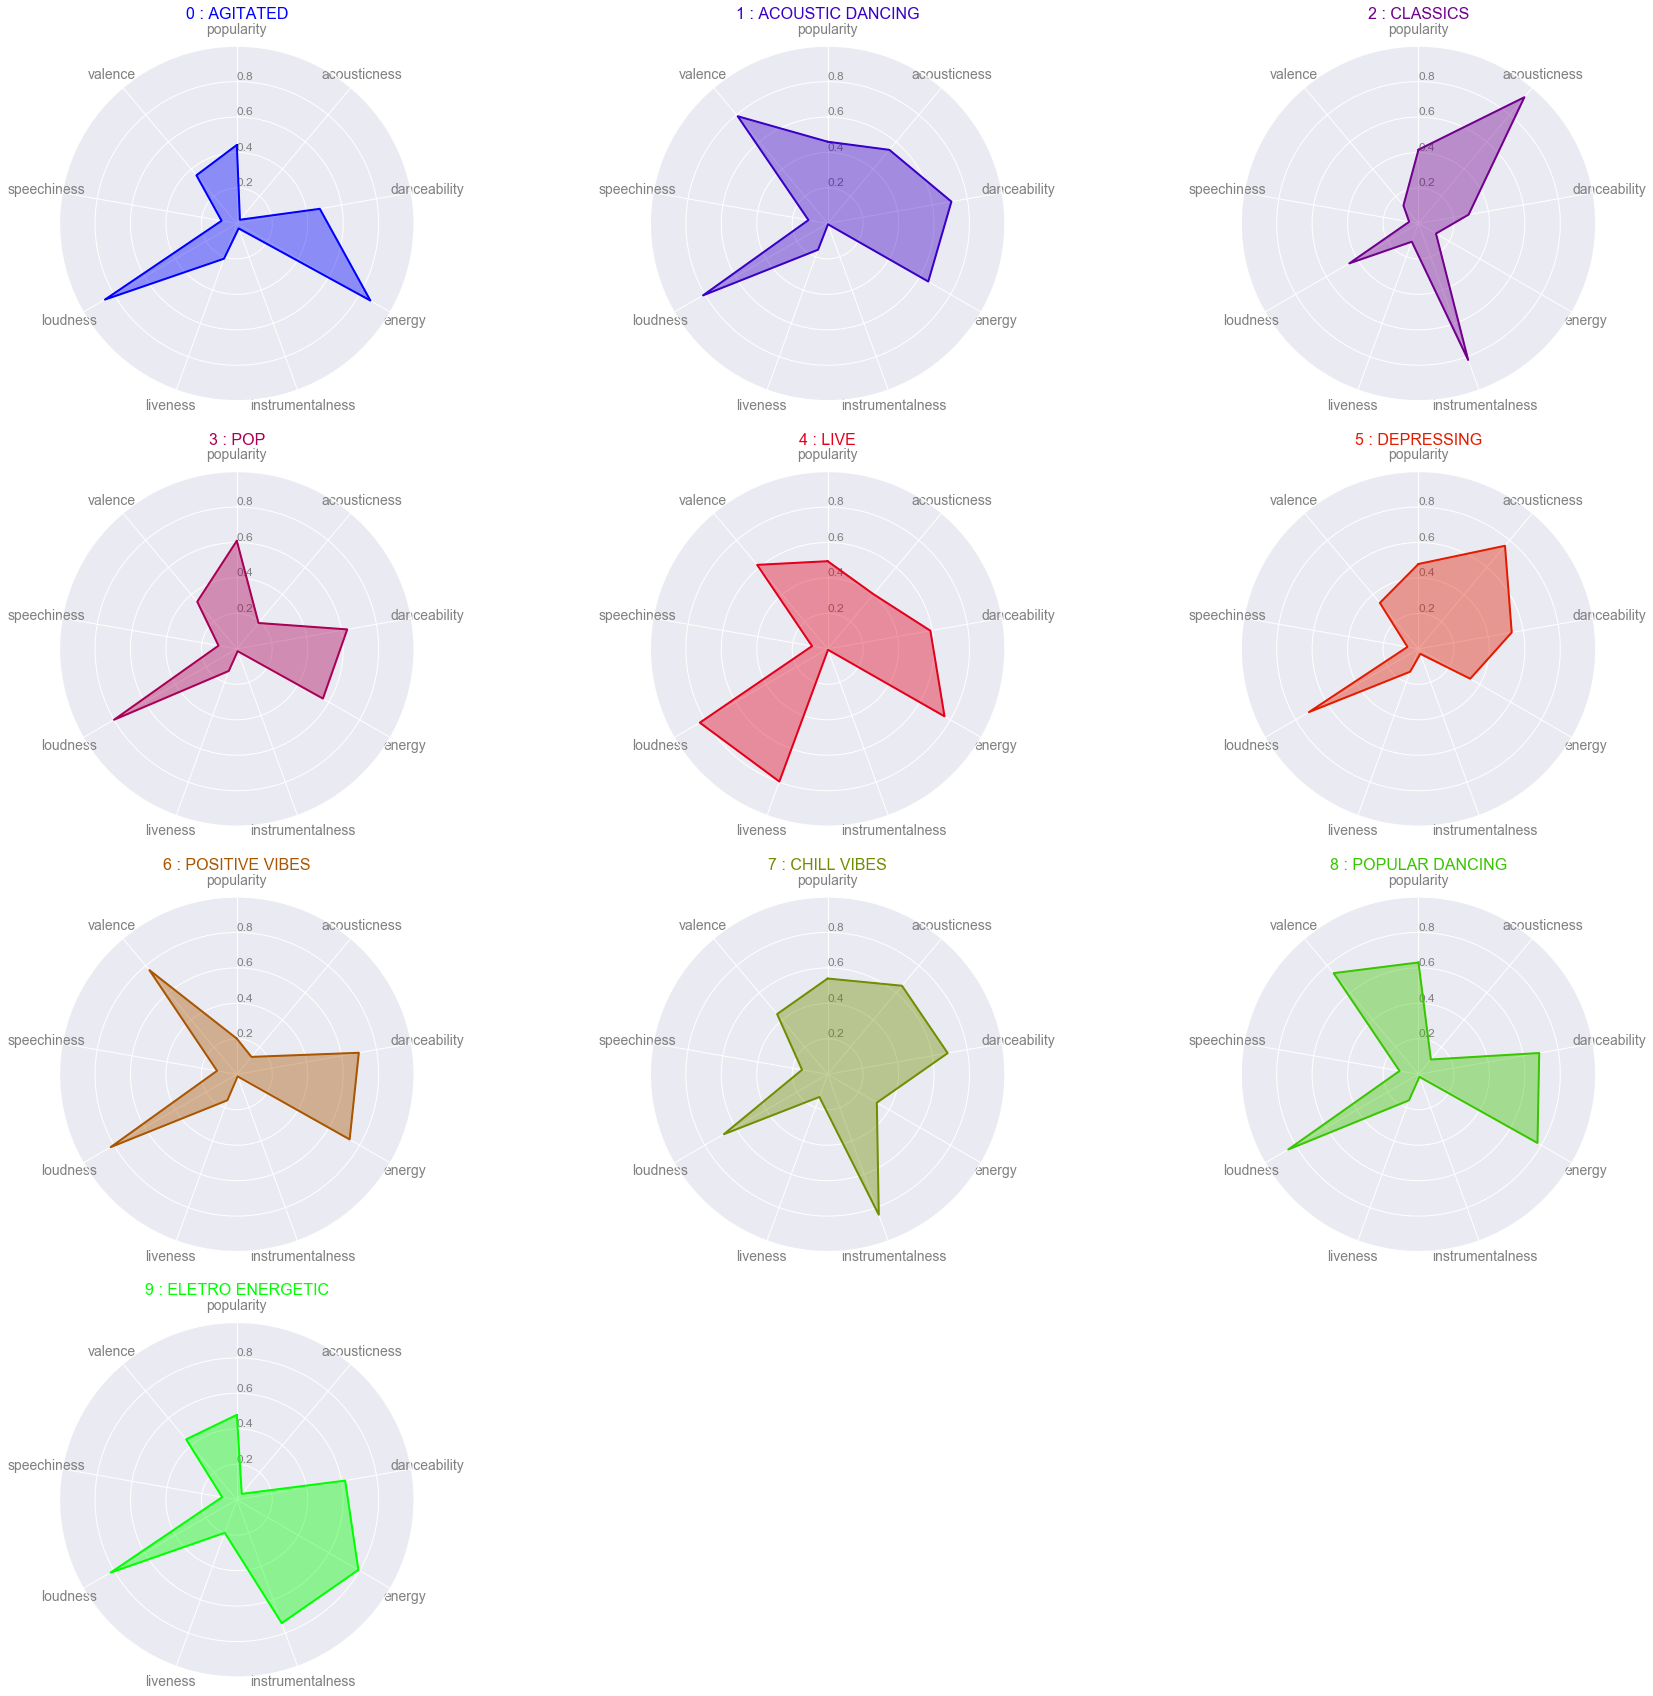

In [292]:
# initialize the figure
plt.figure(figsize=(30,30))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("brg", len(df_radar.index))

# Create cluster name
title_list = ['AGITATED', 'ACOUSTIC DANCING', 'CLASSICS', 'POP', 
              'LIVE', 'DEPRESSING', 'POSITIVE VIBES', 'CHILL VIBES', 
              'POPULAR DANCING', 'ELETRO ENERGETIC']

# Loop to plot
for row in range(0, len(df_radar.index)):
    make_radar(row=row, title=str(df_radar['cluster'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar, num_clusters=len(df_radar.index))

### Applying PCA to visualize the clusters

In [293]:
pca = PCA(n_components=3, random_state=42)
songs_pca = pca.fit_transform(songs_scaled)
pca.explained_variance_ratio_.sum()

0.661244874175988

In [294]:
df_pca = pd.DataFrame(songs_pca, columns=['C1', 'C2', 'C3'])
df_pca['cluster'] = model.labels_
df_pca.head()

,C1,C2,C3,cluster
0,-0.216150,-0.396800,0.005520,1
1,-0.091717,-0.441951,-0.049434,1
2,0.757446,-0.008880,-0.266392,5
3,0.037356,0.043257,-0.021921,3
4,0.122819,-0.147323,0.043899,1


- Undersampling clusters

In [295]:
sampled_clusters_pca = pd.DataFrame()

for c in df_pca.cluster.unique():
    df_cluster_sampled_pca = df_pca[df_pca.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_pca = pd.concat([sampled_clusters_pca,df_cluster_sampled_pca], axis=0)
sampled_clusters_pca.cluster.value_counts()

9    162
8    162
7    162
6    162
5    162
4    162
3    162
2    162
1    162
0    162
Name: cluster, dtype: int64

- Visualizing clusters in 2 dimensions

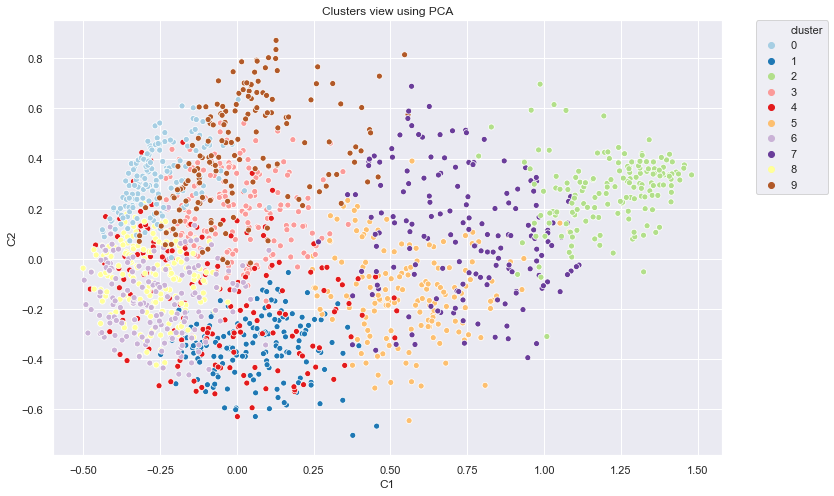

In [296]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_pca, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Clusters view using PCA')
plt.show()

- Visualizing clusters in 3 dimensions

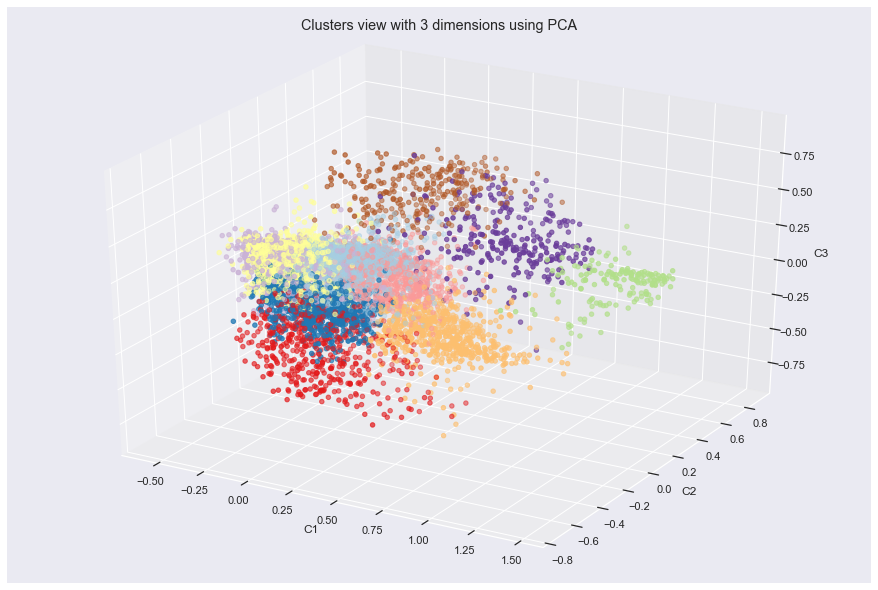

In [297]:
fig = plt.figure()
fig.suptitle('Clusters view with 3 dimensions using PCA')
ax = Axes3D(fig)

ax.scatter(df_pca['C1'], df_pca['C2'], df_pca['C3'],
           c=df_pca['cluster'], cmap='Paired')

ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')
plt.show()

### Applying t-SNE to visualizing the clusters

In [298]:
#tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=42, learning_rate=190)
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
songs_tsne = tsne.fit_transform(songs_scaled)

In [299]:
df_tsne = pd.DataFrame(songs_tsne, columns=['C1', 'C2'])
df_tsne['cluster'] = model.labels_
df_tsne.head()

,C1,C2,cluster
0,-30.997292,31.497871,1
1,-32.823841,34.436462,1
2,25.035284,55.662899,5
3,14.640946,7.547970,3
4,8.820824,27.120035,1


- Undersampling clusters

In [300]:
sampled_clusters_tsne = pd.DataFrame()

for c in df_tsne.cluster.unique():
    df_cluster_sampled_tsne = df_tsne[df_tsne.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_tsne = pd.concat([sampled_clusters_tsne,df_cluster_sampled_tsne], axis=0)
sampled_clusters_tsne.cluster.value_counts()

9    162
8    162
7    162
6    162
5    162
4    162
3    162
2    162
1    162
0    162
Name: cluster, dtype: int64

- Visualizing clusters in 2 dimensions

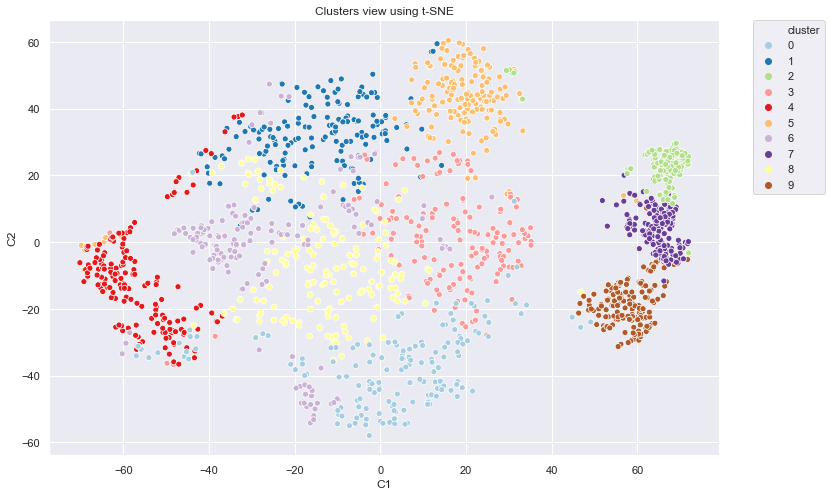

In [301]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_tsne, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Clusters view using t-SNE')
plt.show()

### Predicting users clusters

In [409]:
user_pred = model.predict(user_scaled)
print('10 first users clusters: ', user_pred[:10])

10 first users clusters:  [0 8 0 6 3 0 0 9 0 5]


- Amount of songs in the users clusters

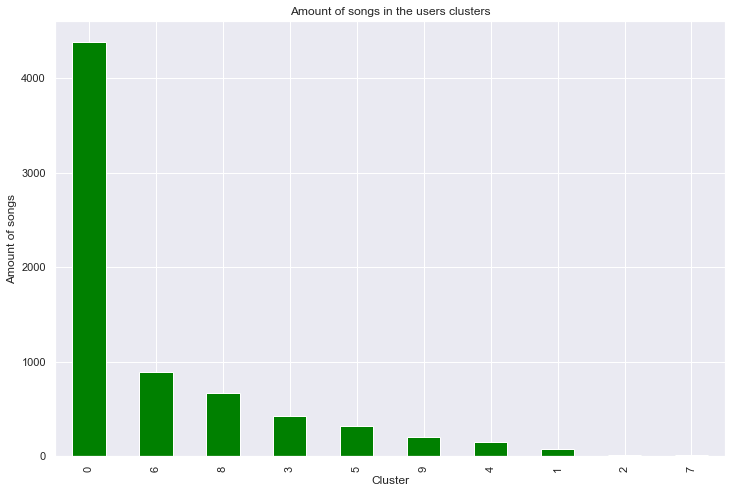

In [410]:
user_cluster = pd.DataFrame(user_scaled, columns=columns_to_cluster_scaled)
user_cluster['cluster'] = user_pred

user_cluster['cluster'].value_counts().plot(kind='bar', color='green')
plt.xlabel('Cluster')
plt.ylabel('Amount of songs')
plt.title('Amount of songs in the users clusters')
plt.show()

- Sample of songs in each cluster

In [411]:
df_user_songs_joined = pd.concat([df_user,user_cluster], axis=1).set_index('cluster')
for cluster in user_cluster['cluster'].unique():
    display(df_user_songs_joined.loc[cluster, ['artist','name','album']].sample(frac=1).head(10))

,artist,name,album
cluster,,,
0,Third Eye Blind,Joke,Thanks for Everything
0,The Fullblast,Shame,Attack.Sustain.Decay
0,The Plot In You,THE ONE YOU LOVED,DISPOSE
0,From First To Last,Worlds Away,From First To Last
0,Journey,Separate Ways (Worlds Apart),The Essential Journey
0,Black Country Communion,Wanderlust,BCCIV
0,Matchbook Romance,"You Can Run, But We'll Find You",Voices
0,blink-182,Cynical,California
0,Dark Station,No Life,No Life


,artist,name,album
cluster,,,
8,Keane,Looking Back,Night Train
8,Trivium,The Heart From Your Hate,The Sin And The Sentence
8,The Ataris,In This Diary,"So Long, Astoria"
8,Paramore,Told You So,Told You So
8,The Fray,Over My Head (Cable Car),How To Save A Life
8,Ed Sheeran,New Man,÷ (Deluxe)
8,Foster The People,Houdini,Torches
8,Modest Mouse,Float On,Good News For People Who Love Bad News
8,Simple Plan,When I'm Gone,Simple Plan


,artist,name,album
cluster,,,
6,Juacas,Eu Dropo o Mundo,"Juacas, Segunda Temporada - Trilha Sonora"
6,Daddy Yankee,Gasolina,Gasolina
6,Silverstein,Retrograde,Retrograde
6,Saves The Day,Rendezvous,9
6,CPM 22,Conta Comigo,Conta Comigo
6,Maroon 5,Help Me Out (with Julia Michaels),Help Me Out
6,Supercombo,Maremotos - Acústica,Maremotos (Acústica)
6,Imagine Dragons,Machine,Machine
6,Dominic,Adiós Buenos Aires,Adiós Buenos Aires


,artist,name,album
cluster,,,
3,Radiohead,Fake Plastic Trees,The Bends [Collectors Edition]
3,Bring Me The Horizon,Drone Bomb Me - Recorded at Spotify Studios NYC,Spotify Singles
3,System Of A Down,Lonely Day,Hypnotize
3,Bullet For My Valentine,Breathe Underwater,Gravity
3,Panic! At The Disco,Nine in the Afternoon - Single Mix,Pretty. Odd.
3,Eagles,Hotel California - 2013 Remaster,The Very Best Of The Eagles (Remastered)
3,Zimbra,"O Tudo, o Nada e o Mundo","O Tudo, o Nada e o Mundo"
3,Third Eye Blind,Jumper - 2006 Remaster,A Collection [w/bonus tracks & interactive boo...
3,Panic! At The Disco,Death of a Bachelor,Death of a Bachelor


,artist,name,album
cluster,,,
9,Fresno,Convicção,Convicção
9,The Who,You Better You Bet - Edit,Maximum As & Bs
9,Circa Survive,Indra's Net,The Amulet (Deluxe)
9,Black Veil Brides,Rebel Yell,Rebels
9,Circa Survive,Dark Pools,Dark Pools
9,Fever Ray,If I Had A Heart,Temporary Secretary
9,Our Last Night,Havana,Havana
9,Martin Garrix,Animals - Extended,Animals (Extended)
9,October Ends,Living in Shadows,A New Path


,artist,name,album
cluster,,,
5,Johnny Cash,Hurt,Unearthed
5,Chris Cornell,Nothing Compares 2 U - Live At SiriusXM/2015,Nothing Compares 2 U / When Bad Does Good
5,Green Day,Ordinary World (feat. Miranda Lambert),Greatest Hits: God's Favorite Band
5,Boyce Avenue,Hallelujah,Hallelujah
5,Boyce Avenue,No Air,"Cover Sessions, Vol. 5"
5,Jake Bugg,Every Colour In The World,Hearts That Strain
5,The Fray,Never Say Never,The Fray
5,Asking Alexandria,Into The Fire - Acoustic Version,Into The Fire (Acoustic Version)
5,BRAZA,Segue o Baile - Ao Vivo,BRAZA no Estúdio Showlivre (Ao Vivo)


,artist,name,album
cluster,,,
1,Ylvis,Sink The Tower,"Stupetårnet (From “Stories From Norway"")"
1,Nirvana,Come As You Are,MTV Unplugged In New York
1,Raimundos,Lugar Ao Sol - Ao Vivo | Acústico,Acústico - Ao Vivo
1,CPM 22,Honrar Teu Nome - Versão Acústica,Honrar Teu Nome (Versão Acústica)
1,Tanner Patrick,Clarity,Clarity
1,Zimbra,Você É A Mais Sincera,Você É A Mais Sincera
1,BRAZA,Qual É o Rosto de Deus?,Tijolo por Tijolo
1,Mike Shinoda,About You (feat. blackbear),About You (feat. blackbear)
1,Boyce Avenue,Every Breath You Take,"Cover Sessions, Vol. 5"


,artist,name,album
cluster,,,
4,Eighteen Visions,Victim,Eighteen Visions
4,Puddle Of Mudd,She Hates Me,Come Clean
4,Selvagens à Procura de Lei,Massarrara - Na Maloca Dragão,Massarrara - Na Maloca Dragão
4,Marcos & Belutti,Aquele 1%,Aquele 1% - Single
4,Mae,The House That Fire Built,(m) (a) (e)
4,Bloc Party,This Modern Love - Live,This Modern Love
4,Moptop,Como Se Comportar,Como Se Comportar
4,Highly Suspect,Lost,Mister Asylum
4,Jet,My Name Is Thunder,My Name Is Thunder


,artist,name,album
cluster,,,
7,Radical Face,"Welcome Home, Son",Ghost
7,Blindside,Midnight - Acoustic,Midnight (Acoustic)
7,AWOLNATION,Sail,Megalithic Symphony
7,Coldplay,Hypnotised - EP Mix,Kaleidoscope EP
7,Cigarettes After Sex,Affection,Affection
7,Eagles Of Death Metal,The Hunger,EODM Presents Boots Electric Performing The Be...
7,Cigarettes After Sex,Heavenly,Heavenly
7,Cigarettes After Sex,Keep On Loving You,Affection
7,BRAZA,Liquidificador - Ao Vivo,BRAZA no Estúdio Showlivre (Ao Vivo)


,artist,name,album
cluster,,,
2,David Sides,Linkin Park - In The End,The Collection Volume 2
2,You Me At Six,Brand New - Acoustic in Amsterdam,Brand New (Acoustic in Amsterdam)
2,You Me At Six,Take on the World - Acoustic in Amsterdam,Take on the World (Acoustic in Amsterdam)
2,The Maine,Transatlanticism,Transatlanticism
2,Mike Shinoda,Nothing Makes Sense Anymore,Crossing A Line / Nothing Makes Sense Anymore
2,The Maine,Transatlanticism,Songs That Saved My Life
2,Pink Floyd,"Another Brick in the Wall, Pt. 1",The Wall
2,Bullet For My Valentine,Under Again - Piano Version,Gravity (Deluxe Edition)
2,Serj Tankian,Gor Digging,Spitak (Original Motion Picture Soundtrack)


### Recommending songs

- Analysing the percentage of songs per cluster

In [412]:
df_user_songs_joined.reset_index(inplace=True)
cluster_pct = df_user_songs_joined.cluster.value_counts(normalize=True)*20

if int(cluster_pct.round(0).sum()) < 20:
    cluster_pct[cluster_pct < 0.5] = cluster_pct[cluster_pct < 0.5] + 1.0
    
display(cluster_pct)
print('Total songs: ', int(cluster_pct.round(0).sum()))

0    12.298415
6     2.501753
8     1.865096
3     1.177955
5     0.891881
9     0.558126
4     0.426308
1     0.204740
2     0.042070
7     0.033656
Name: cluster, dtype: float64

Total songs:  20


In [413]:
df_songs_joined.reset_index(inplace=True)
df_songs_joined.head(3)

,cluster,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,...,valence,popularity_scaled,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,loudness_scaled,speechiness_scaled,valence_scaled
0,1,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,137826,3mf4l3O9xn8JukaUETnZFt,Chá De Sofrimento,37,0.411,...,0.933,0.37,0.412650,0.678899,0.859824,0.000000,0.302758,0.891080,0.033628,0.948171
1,1,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,145883,48cryfhSXQGrWyhnmXEOEg,Nota 1.000,38,0.564,...,0.871,0.38,0.566264,0.720693,0.851814,0.000095,0.319285,0.863885,0.035619,0.885163
2,5,Deixa,7wj45LWz6uIcyBd8iqdlZ5,Bruna Magalhães,108y6vREhgAIvgvm1Cq54p,207209,0m52ru9yO561lgoMHyclcC,Deixa,0,0.801,...,0.180,0.00,0.804217,0.304791,0.158944,0.000000,0.041525,0.596297,0.039491,0.182927


- Adding the percentage to the users dataset

In [414]:
df_user_songs_joined['cluster_pct'] = df_user_songs_joined['cluster'].apply(lambda c: cluster_pct[c])
df_user_songs_joined.drop(columns=columns_to_cluster_scaled, inplace=True)
df_user_songs_joined.head(3)

,cluster,name,id,popularity,duration_ms,album,album_id,artist,artist_id,speechiness,...,mode,liveness,key,danceability,loudness,acousticness,instrumentalness,energy,tempo,cluster_pct
0,0,Motions,5p1PQOz5uCa2oMRKkX0oKI,36,180000,Skeletons,6uc6QxoKV2rtCssHIH4BQe,Driveways,4OuSiJSnuRsK0dTM0dtm1R,0.1090,...,0,0.137,3,0.485,-6.169,0.001530,0.000000,0.977,138.967,12.298415
1,8,South of the Border (feat. Camila Cabello & Ca...,3vQhEd4lOg4mAV6CHCgoHW,72,173454,South of the Border (feat. Camila Cabello & Ca...,05Bru0ZVTxp4orAyrZIA77,Ed Sheeran,6eUKZXaKkcviH0Ku9w2n3V,0.0404,...,1,0.335,5,0.789,-4.388,0.220000,0.000046,0.858,110.012,1.865096
2,0,Nostalgia,2VEwYtDHSemqPhMOGixhPg,31,242800,Mr. Pain,3Q89u9avFB7FjtWej4OV30,Dayshell,4yextvMjXxQXzyQkyS1jYX,0.0300,...,1,0.291,1,0.502,-3.299,0.000312,0.000000,0.891,98.998,12.298415


- Getting mixed samples from the original dataset and inserting in a new playlist, based on the percentage of songs present in each user cluster

In [415]:
playlist = pd.DataFrame()

for ncluster, pct in cluster_pct.items():
    songs = df_songs_joined[df_songs_joined['cluster'] == ncluster].sample(n=int(round(pct, 0)))
    playlist = pd.concat([playlist,songs], ignore_index=True)
    if len(playlist) > 20 :
        flag = 20 - len(playlist)
        playlist = playlist[:flag]
playlist.head(3)

,cluster,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,...,valence,popularity_scaled,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,loudness_scaled,speechiness_scaled,valence_scaled
0,0,Fade,5ipLw8pJR65yPyylZCqBT0,Catch Your Breath,2fqPOGxG12nEERj8YG7p22,205750,6GS7dWKyY8vCJHaThLZVEz,Fade,47,0.00027,...,0.204,0.47,0.000269,0.601427,0.873842,0.000002,0.048755,0.849499,0.116150,0.207317
1,0,Spotify Singles,32iqkyCIOKogzuExLw1WTQ,Bring Me The Horizon,1Ffb6ejR6Fe5IamqA5oRUF,232661,0yQUNTyGO1HHMvXY3TZh7t,Drone Bomb Me - Recorded at Spotify Studios NYC,51,0.20800,...,0.418,0.51,0.208834,0.533129,0.727658,0.006079,0.351307,0.760581,0.051659,0.424797
2,0,Does This Look Infected?,2iOJEUCKJaYseov1qA8ot8,Sum 41,0qT79UgT5tY4yudH9VfsdT,158733,0jqK7sGTLsHPkQrrcrGuKD,Still Waiting,70,0.00105,...,0.560,0.70,0.001052,0.439348,0.950938,0.000037,0.259374,0.865974,0.287611,0.569106


### User EDA vs New playlist

In [416]:
playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 29 columns):
cluster                    20 non-null int64
album                      20 non-null object
album_id                   20 non-null object
artist                     20 non-null object
artist_id                  20 non-null object
duration_ms                20 non-null int64
id                         20 non-null object
name                       20 non-null object
popularity                 20 non-null int64
acousticness               20 non-null float64
danceability               20 non-null float64
energy                     20 non-null float64
instrumentalness           20 non-null float64
key                        20 non-null int64
liveness                   20 non-null float64
loudness                   20 non-null float64
mode                       20 non-null int64
speechiness                20 non-null float64
tempo                      20 non-null float64
valence             

In [417]:
playlist[['name', 'artist', 'album', 'cluster']]

,name,artist,album,cluster
0,Fade,Catch Your Breath,Fade,0
1,Drone Bomb Me - Recorded at Spotify Studios NYC,Bring Me The Horizon,Spotify Singles,0
2,Still Waiting,Sum 41,Does This Look Infected?,0
3,Prayer Of The Refugee,Rise Against,Endgame / Appeal To Reason / Siren Song Of The...,0
4,O Tempo Não Pára - Ao Vivo,Cazuza,Novo Millennium,0
5,I Wanna Be Your Dog,The Stooges,The Stooges,0
6,Cherry-coloured Funk,Cocteau Twins,Heaven Or Las Vegas (Remastered),0
7,Painted Memories,Third Season,Painted Memories,0
8,It's Only Love,Micar,It's Only Love,0
9,For What It's Worth,"Sincerely, Me",Half Empty,0


In [418]:
playlist.describe()

,cluster,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,...,valence,popularity_scaled,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,loudness_scaled,speechiness_scaled,valence_scaled
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2.550000,232302.950000,43.650000,0.078207,0.491900,0.805800,0.072354,5.750000,0.251960,-6.777800,...,0.477800,0.436500,0.078520,0.501427,0.806557,0.073681,0.238674,0.822819,0.074181,0.485569
std,3.410124,56269.752352,20.974358,0.169727,0.133194,0.161444,0.213320,3.306692,0.202827,3.083492,...,0.172834,0.209744,0.170409,0.135774,0.161647,0.217230,0.209510,0.071549,0.060890,0.175644
min,0.000000,149506.000000,1.000000,0.000270,0.200000,0.381000,0.000000,1.000000,0.063000,-13.407000,...,0.107000,0.010000,0.000269,0.203874,0.381223,0.000000,0.043487,0.668995,0.032080,0.108740
25%,0.000000,191489.500000,35.750000,0.002070,0.401750,0.765250,0.000000,2.750000,0.105250,-8.896000,...,0.381750,0.357500,0.002076,0.409531,0.765956,0.000000,0.087129,0.773668,0.041067,0.387957
50%,0.000000,223210.500000,48.000000,0.011650,0.497000,0.857500,0.000025,6.000000,0.145500,-5.972000,...,0.439500,0.480000,0.011695,0.506626,0.858322,0.000026,0.128706,0.841517,0.054535,0.446646
75%,6.000000,273755.500000,59.250000,0.036150,0.567500,0.917250,0.002012,8.000000,0.361000,-4.491250,...,0.593750,0.592500,0.036293,0.578491,0.918147,0.002049,0.351307,0.875876,0.069082,0.603404
max,9.000000,351866.000000,75.000000,0.722000,0.806000,0.987000,0.894000,11.000000,0.662000,-3.255000,...,0.849000,0.750000,0.724899,0.821611,0.987985,0.910387,0.662225,0.904562,0.287611,0.862805


- Comparing features between user x playlist

In [419]:
def plot_recomendations_similarities(data, variables):
    root = int(np.ceil(np.sqrt(len(variables))))
    fig, axis = plt.subplots(nrows=root, ncols=root, figsize=(15, 15))
    
    numeric_categories = ["0.0 - 0.2",
                           "0.2 - 0.4",
                           "0.4 - 0.6",
                           "0.6 - 0.8",
                           "0.8 - 1.0",
                           ]
    fig.suptitle('Comparing distributions for the songs features')
    for idx, column in enumerate(variables):
        i, j = idx % root, idx // root
        ax = axis[j][i]
        
        grouped = data.groupby('user')[[column, 'user']]
        
        for user, group in grouped:
            sns.distplot(group[column], ax=ax, label=user, bins=20)
        ax.legend()
    plt.show()

In [420]:
df_user_songs_joined['user'] = 'User'
playlist['user'] = 'Playlist'

user = df_user_songs_joined.drop(columns='cluster_pct')

display(user.head(1))
playlist.head(1)

,cluster,name,id,popularity,duration_ms,album,album_id,artist,artist_id,speechiness,...,mode,liveness,key,danceability,loudness,acousticness,instrumentalness,energy,tempo,user
0,0,Motions,5p1PQOz5uCa2oMRKkX0oKI,36,180000,Skeletons,6uc6QxoKV2rtCssHIH4BQe,Driveways,4OuSiJSnuRsK0dTM0dtm1R,0.109,...,0,0.137,3,0.485,-6.169,0.00153,0.0,0.977,138.967,User


,cluster,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,...,popularity_scaled,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,liveness_scaled,loudness_scaled,speechiness_scaled,valence_scaled,user
0,0,Fade,5ipLw8pJR65yPyylZCqBT0,Catch Your Breath,2fqPOGxG12nEERj8YG7p22,205750,6GS7dWKyY8vCJHaThLZVEz,Fade,47,0.00027,...,0.47,0.000269,0.601427,0.873842,0.000002,0.048755,0.849499,0.11615,0.207317,Playlist


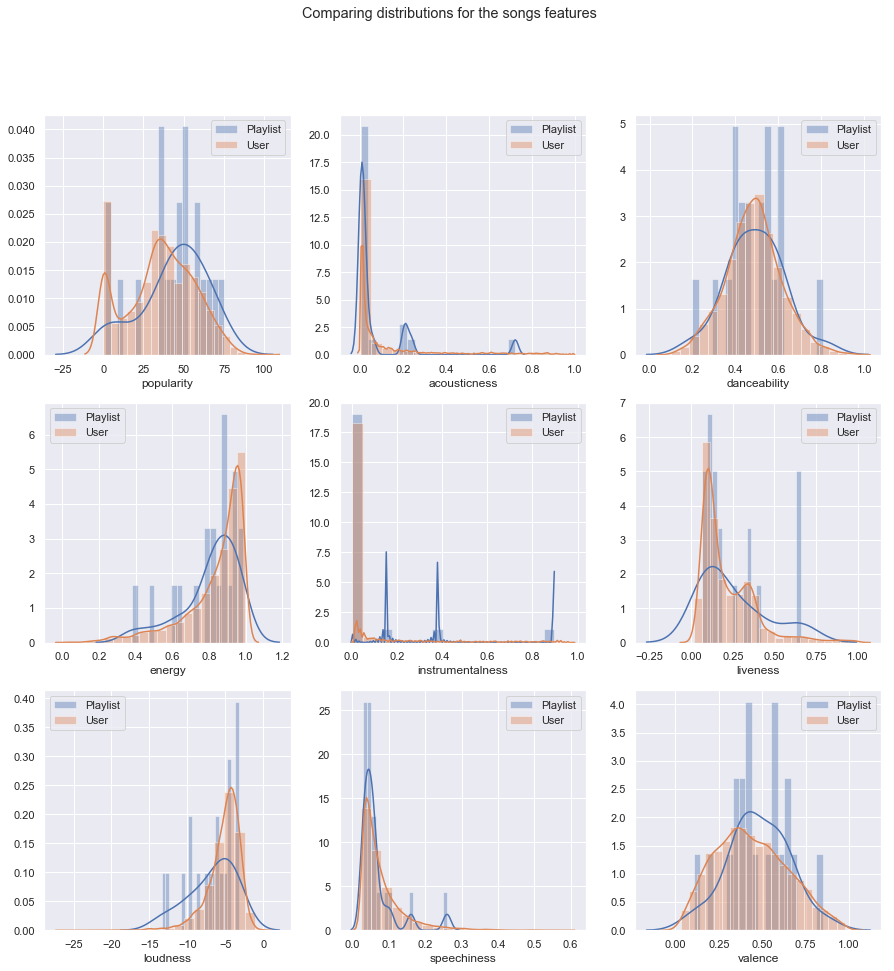

In [421]:
user_x_playlist = user.append(playlist)
plot_recomendations_similarities(user_x_playlist, columns_to_cluster)

### Exporting generated playlist

- To csv

In [422]:
playlist.drop(columns=columns_to_cluster_scaled, inplace=True)
playlist.to_csv('datasets/generated_playlists/my_playlist.csv', index=False)

- To Spotify

In [317]:
my_user = '12144777067'

session = SpotifySession(my_user)



         User authentication requires interaction with your
         web browser. Once you enter your credentials and
         give authorization, you will be redirected to
         a url.  Paste that url you were directed to to
         complete the authorization.

     
Opened https://accounts.spotify.com/authorize?client_id=f4bd9bcb87724721ab5b0a9667f1ae52&response_type=code&redirect_uri=https%3A%2F%2Fedujtm.github.io%2Fdiversify%2Fredirect&scope=playlist-modify-private+user-library-read in your browser


Enter the the code pattern you were given: AQCyGoVzL-vMyHeEm_kqHa4PrIq-ltKORDHmTb3NAMjVCW4K8a4ziFaZH5M1Ee96B7JBZgKUFtUtejoaZqG9y63yCfmZZWKJUHg-BhinjkJTRlWlM8nOf6yp8kRN7PdPJ_8xEMdjGL7nNkBizeYEcLTpCjPLx_RJJ-bEfPoz6JOA9EimaMHfeLYkUMjRzYbF1TcZOZdjES-ZtBvR3ofWsmdVHYGjJVuUyfNFux00zjhg7n6kJ9fHzhE_y88mIDMETj8uByKLCsrsVsax6mtS




In [423]:
session.tracks_to_playlist(trackids=playlist['id'], name='My Playlist 2.0')

### Some possible improvements

- Sampling dataset
- Using more or less features
- Using more or less clusters
- Using different scaler
- Increase train dataset size
- Decrease playlist size
- Take off random_state attributes
- Use another clustering algorithm